# Collaborative Filtering

The following file summarizes the performed collaborative filtering methods.

In [ ]:
%run functions.py

# Import packages
import numpy as np
import pandas as pd

from surprise import SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, NormalPredictor
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV, ShuffleSplit

# Load dataset
interactions = pd.read_csv('../data/RAW_interactions.csv', sep=',')
recipes = pd.read_csv('../data/RAW_recipes.csv', sep=',')
print('Unique rows in interactions: ', len(interactions))
print('Unique rows in recipes: ', len(recipes))

## Filter Strategies

In [16]:
# Extract only the relevant columns from the data set
ratings = interactions[['user_id', 'recipe_id', 'rating']].copy()

# Delete all '0' ratings
ratings = ratings[ratings.rating != 0]

# Create a dictonary that stores all of our filtering possibilities
filters = {"IQR": apply_filter(ratings, ["user_id", "recipe_id"], "iqr_filtering"),
           "random_sampling": apply_filter(ratings, ["user_id", "recipe_id"], "random_sampling", sample_size=5000)}

## Algorithms

In [8]:
# Prep grid search

# Params
param_grid = {
    "KNNBasic" : {
        "k" : [20,40,60],
        "sim_options" : {
            "name" : ['cosine'],
            "user_based"  : [True, False],
        }
    },
    "KNNWithMeans" : {
        "k" : [20,40,60],
        "sim_options" : {
            "name" : ['cosine'],
            "user_based"  : [True, False],
        }                       
    },          
    "SVD" : {
        "n_factors" : [5, 15, 25, 50]
    },
    "NMF" : {
        "n_factors" : [5, 15, 25, 50]
    },
    "Baseline" : {}
}


# Algos
algos = {"SVD" : SVD, "NMF" : NMF, "Baseline" : NormalPredictor}

## Evaluation

In [17]:
# Test plot function
filtered_ratings = filters.get("random_sampling")

# Create train-test split for model evaluation
ratings_train, ratings_test = train_test_split(filtered_ratings, test_size=0.3, random_state=42, shuffle=True, stratify=filtered_ratings.rating)

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(ratings_train, Reader())
testset = Dataset.load_from_df(ratings_test, Reader()).build_full_trainset().build_testset()

knnbasic_cv = cross_validate(KNNBasic(), trainset, cv=5, n_jobs=5, verbose=False)

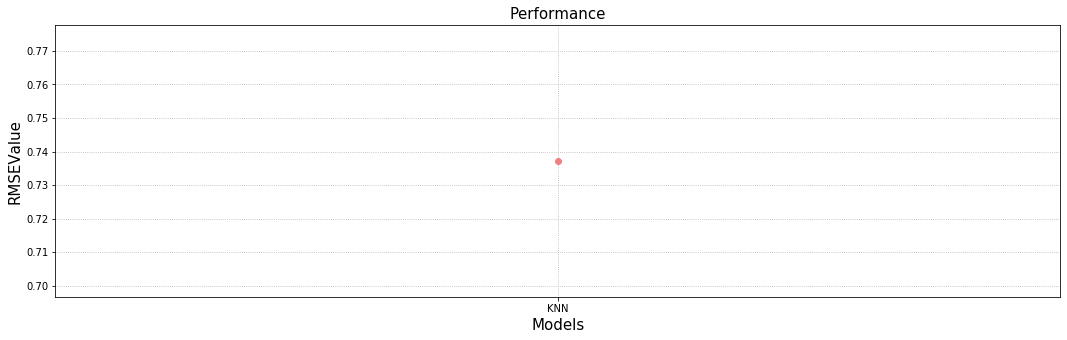

In [36]:
name = ["KNN"]

evaluation_plot([knnbasic_cv], name)

In [5]:
# Benchmark
benchmark = []
fitted_algos = {}

# Cross-validation
cv = ShuffleSplit(n_splits = 5, test_size = 0.3, random_state=42, shuffle=True)

# Evaluate the algorithms
for f_name, f in filters.items():
    
    # Apply the current filtering
    ratings = f
    
    # Print the key facts for the filtering
    print_filter_results(ratings, interactions)
    
    # Create train-test split for model evaluation
    ratings_train, ratings_test = train_test_split(ratings, test_size=0.3, random_state=42, shuffle=True, stratify=ratings.rating)
    
    # Create dataset objects from the train-test-split which is required for suprise package 
    trainset = Dataset.load_from_df(ratings_train, Reader())
    testset = Dataset.load_from_df(ratings_test, Reader()).build_full_trainset().build_testset()
    
    # Run a grid search for each algorithm
    for name, algo in algos.items():
        gs = GridSearchCV(algo, param_grid.get(name), measures=['rmse'], cv=cv, refit=True, n_jobs=-1)
        
        # Refit the estimator with the best parameters on whole training set
        gs.fit(trainset)
        
        # Get the final score
        predicitons = gs.test(testset)
        final_score = accuracy.rmse(predicitons)
        
        # Store the fitted estimator for later use
        fitted_algos[name] = gs
       
        # Store the results
        benchmark.append([f_name, name, final_score, gs.best_params])
        
        # Print results

results = pd.DataFrame(benchmark, columns=["Filter", "Algorithm", "Final_RMSE", "Params"]).sort_values("Final_RMSE")
results.set_index(["Filter", "Algorithm"], inplace=True)
results.sort_index(inplace=True)
results

Number of ratings that is left: 77654

Number of users that is left: 70118

Number of recipes that is left: 56457

Fraction of ratings that is left: 0.07

Fraction of users that is left: 0.31

Fraction of recipes that is left: 0.24

RMSE: 1.0177
RMSE: 1.0360
RMSE: 1.2979
Number of ratings that is left: 102802

Number of users that is left: 29353

Number of recipes that is left: 43935

Fraction of ratings that is left: 0.09

Fraction of users that is left: 0.13

Fraction of recipes that is left: 0.19

RMSE: 0.6877
RMSE: 0.7410
RMSE: 0.9047


Final_RMSE                       Params
Filter          Algorithm                                         
IQR             Baseline     1.297916                 {'rmse': {}}
                NMF          1.035950  {'rmse': {'n_factors': 50}}
                SVD          1.017690   {'rmse': {'n_factors': 5}}
random_sampling Baseline     0.904658                 {'rmse': {}}
                NMF          0.741033  {'rmse': {'n_factors': 50}}
                SVD          0.687691   {'rmse': {'n_factors': 5}}